In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import math
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='CRITICAL')

import os
import sys
from pathlib import Path
import IPython.display as ipd
from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Math import *
from PySpice.Plot.BodeDiagram import bode_diagram
from PySpice.Plot.BodeDiagram import bode_diagram_gain

import schemdraw
import schemdraw.elements as elm
from schemdraw import logic
from schemdraw import dsp

## setup spice library path
directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)
## set the project directory as directory_path
directory_path = Path(os.path.abspath('')).resolve()

# about


### *frequency doubler*

In [2]:
#load the diffpair schema
kicad_netlist_path = directory_path.joinpath('main', 'main.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

In [3]:
#simulate interpolating scanner
doubler = parser.build_circuit(ground=5)
doubler.include(spice_library['TL072'])
doubler.include(spice_library['TL072c'])
#doubler.include(spice_library['LT1014x_30V'])
#doubler.include(spice_library['BC556B'])
#doubler.include(spice_library['BC857CW'])
#doubler.include(spice_library['LM13700/NS'])
#doubler.include(spice_library['LM13700d'])
#doubler.include(spice_library['D1N4148'])
doubler.V('1', '+15V', doubler.gnd, 'DC 15')
doubler.V('2', '-15V', doubler.gnd, 'DC -15')
doubler.V('3', 'SAW_IN', doubler.gnd, 'DC 5V AC 5V PULSE(-5 5 0 10m 0 1u 10m)')
#doubler.V('4', 'IN_2', doubler.gnd, 'DC 5V AC 5V SIN(0 5 800)')
#doubler.V('5', 'IN_3', doubler.gnd, 'DC 5V AC 5V SIN(0 5 1200)')
#doubler.V('6', 'IN_4', doubler.gnd, 'DC 5V AC 5V SIN(0 5 1600)')
#doubler.V('7', 'CV_IN', doubler.gnd, 'DC 5V AC 5V PULSE(0 5 0 30m 0 1u 30m)') 

simulator = doubler.simulator(temperature=25, nominal_temperature=25)
analysis_doubler = simulator.transient(step_time=1@u_us, end_time=40@u_ms)

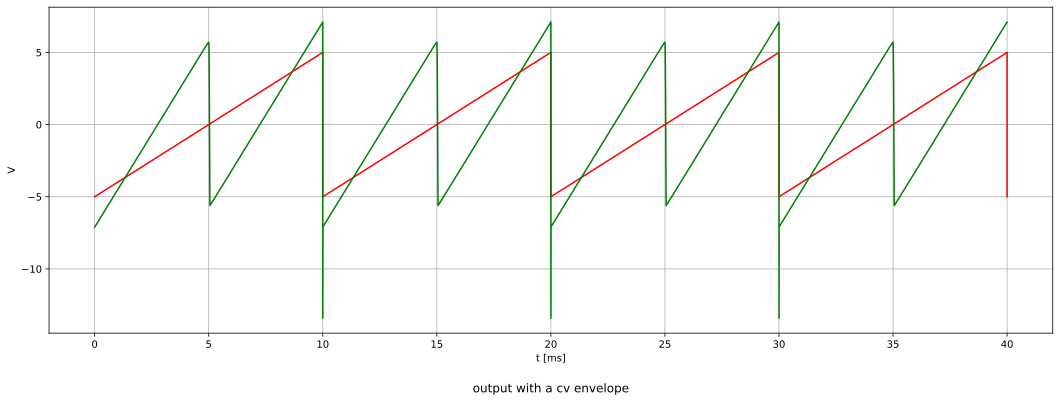

In [4]:
#plot the results
fig, ax0 = plt.subplots(figsize=(18, 6))

#plot cv
ax0.plot(u_ms(analysis_doubler['SAW_IN'].abscissa), analysis_doubler['SAW_IN'], c='Red')
ax0.plot(u_ms(analysis_doubler['OUT'].abscissa), analysis_doubler['OUT'], c='Green')

ax0.grid()
ax0.set_xlabel('t [ms]')
ax0.set_ylabel('V')
ax0.set_title('output with a cv envelope', y=-0.2)

plt.show()


with a sine input

In [5]:
#simulate interpolating scanner
doubler = parser.build_circuit(ground=5)
doubler.include(spice_library['TL072'])
doubler.include(spice_library['TL072c'])
doubler.V('1', '+15V', doubler.gnd, 'DC 15')
doubler.V('2', '-15V', doubler.gnd, 'DC -15')
doubler.V('6', 'SAW_IN', doubler.gnd, 'DC 5V AC 5V SIN(0 5 100)')

simulator = doubler.simulator(temperature=25, nominal_temperature=25)
analysis_doubler = simulator.transient(step_time=1@u_us, end_time=40@u_ms)

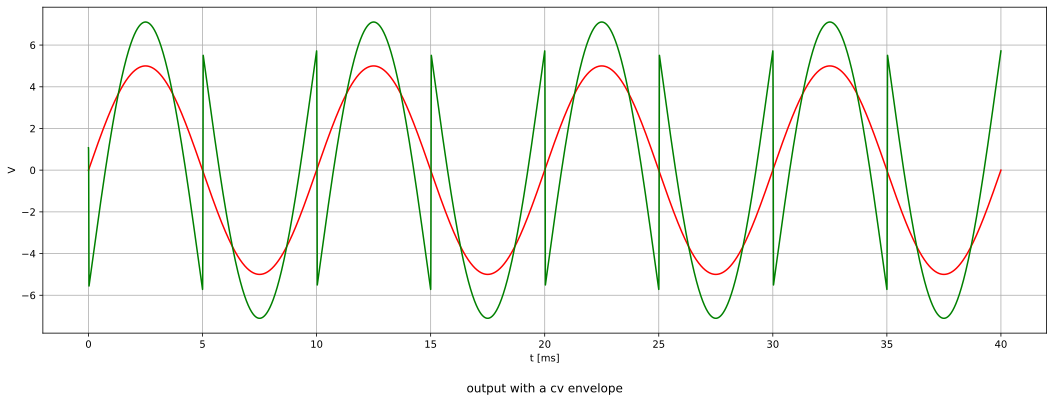

In [6]:
#plot the results
fig, ax0 = plt.subplots(figsize=(18, 6))

#plot cv
ax0.plot(u_ms(analysis_doubler['SAW_IN'].abscissa), analysis_doubler['SAW_IN'], c='Red')
ax0.plot(u_ms(analysis_doubler['OUT'].abscissa), analysis_doubler['OUT'], c='Green')

ax0.grid()
ax0.set_xlabel('t [ms]')
ax0.set_ylabel('V')
ax0.set_title('output with a cv envelope', y=-0.2)

plt.show()

### *frequency shifter*

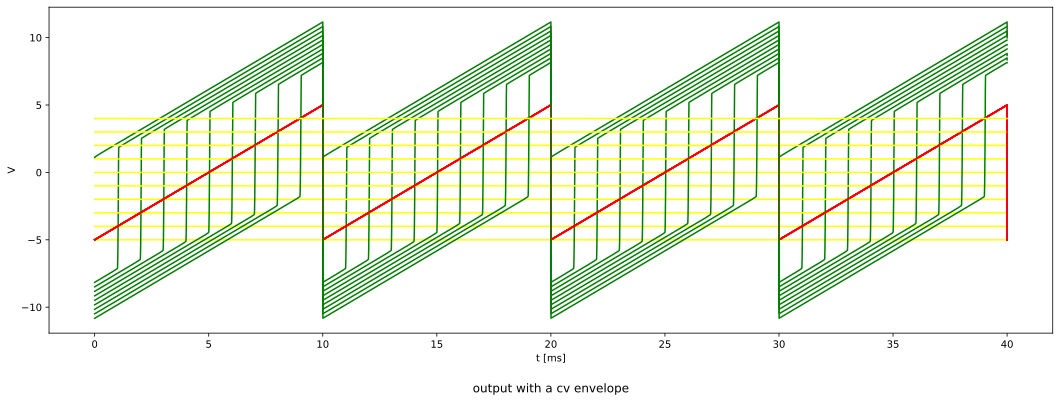

In [7]:
#load frequency shifter schema
kicad_netlist_path = directory_path.joinpath('shifter', 'shifter.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

#plot the results
fig, ax0 = plt.subplots(figsize=(18, 6))

for shift in np.arange(-5, 5, 1) :
    #simulate 
    shifter = parser.build_circuit(ground=5)
    shifter.include(spice_library['TL072'])
    shifter.include(spice_library['TL072c'])
    shifter.V('1', '+15V', shifter.gnd, 'DC 15')
    shifter.V('2', '-15V', shifter.gnd, 'DC -15')
    shifter.V('3', 'SAW_IN', shifter.gnd, 'DC 5V AC 5V PULSE(-5 5 0 10m 0 1u 10m)')
    shifter.V('4', 'PHASE_SHIFT', shifter.gnd, '%dV' % shift) #'DC 5V AC 5V PULSE(-5 5 0 10m 0 1u 10m)')

    simulator = shifter.simulator(temperature=25, nominal_temperature=25)
    analysis_shifter = simulator.transient(step_time=1@u_us, end_time=40@u_ms)

    #plot cv
    ax0.plot(u_ms(analysis_shifter['SAW_IN'].abscissa), analysis_shifter['SAW_IN'], c='Red')
    ax0.plot(u_ms(analysis_shifter['OUT'].abscissa), analysis_shifter['OUT'], c='Green')
    ax0.plot(u_ms(analysis_shifter['PHASE_SHIFT'].abscissa), analysis_shifter['PHASE_SHIFT'], c='Yellow')

    ax0.grid()
    ax0.set_xlabel('t [ms]')
    ax0.set_ylabel('V')
    ax0.set_title('output with a cv envelope', y=-0.2)

plt.show()



shifter with two sines

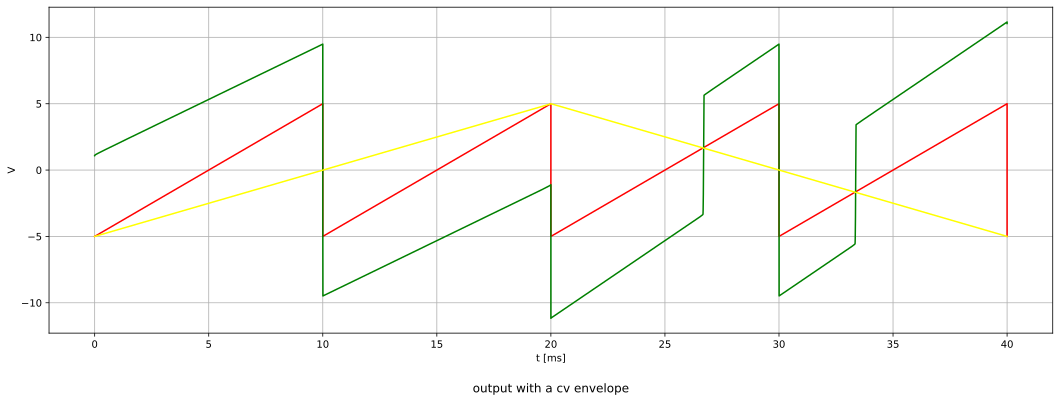

In [8]:
#load frequency shifter schema
kicad_netlist_path = directory_path.joinpath('shifter', 'shifter.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

#plot the results
fig, ax0 = plt.subplots(figsize=(18, 6))

#simulate 
shifter = parser.build_circuit(ground=5)
shifter.include(spice_library['TL072'])
shifter.include(spice_library['TL072c'])
shifter.V('1', '+15V', shifter.gnd, 'DC 15')
shifter.V('2', '-15V', shifter.gnd, 'DC -15')
shifter.V('3', 'SAW_IN', doubler.gnd, 'DC 5V AC 5V PULSE(-5 5 0 10m 0 1u 10m)')
shifter.V('4', 'PHASE_SHIFT', doubler.gnd, 'DC 5V AC 5V PULSE(-5 5 0 20m 20m 1u 40m)')

simulator = shifter.simulator(temperature=25, nominal_temperature=25)
analysis_shifter = simulator.transient(step_time=1@u_us, end_time=40@u_ms)

#plot cv
ax0.plot(u_ms(analysis_shifter['SAW_IN'].abscissa), analysis_shifter['SAW_IN'], c='Red')
ax0.plot(u_ms(analysis_shifter['OUT'].abscissa), analysis_shifter['OUT'], c='Green')
ax0.plot(u_ms(analysis_shifter['PHASE_SHIFT'].abscissa), analysis_shifter['PHASE_SHIFT'], c='Yellow')

ax0.grid()
ax0.set_xlabel('t [ms]')
ax0.set_ylabel('V')
ax0.set_title('output with a cv envelope', y=-0.2)

plt.show()

fast modulator

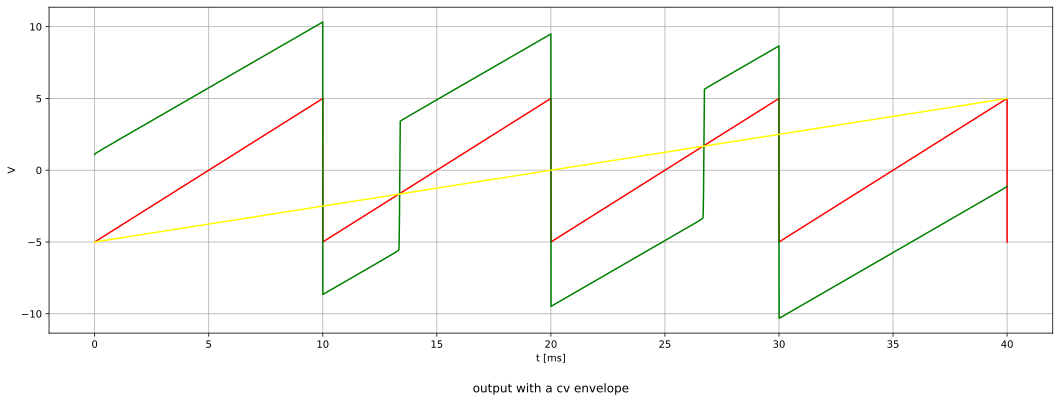

In [9]:
#load frequency shifter schema
kicad_netlist_path = directory_path.joinpath('shifter', 'shifter.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

#plot the results
fig, ax0 = plt.subplots(figsize=(18, 6))

#simulate 
shifter = parser.build_circuit(ground=5)
shifter.include(spice_library['TL072'])
shifter.include(spice_library['TL072c'])
shifter.V('1', '+15V', shifter.gnd, 'DC 15')
shifter.V('2', '-15V', shifter.gnd, 'DC -15')
shifter.V('3', 'SAW_IN', shifter.gnd, 'DC 5V AC 5V PULSE(-5 5 0 10m 0 1u 10m)')
shifter.V('4', 'PHASE_SHIFT', shifter.gnd, 'DC 5V AC 5V PULSE(-5 5 0 40m 0 1u 40m)')

simulator = shifter.simulator(temperature=25, nominal_temperature=25)
analysis_shifter = simulator.transient(step_time=1@u_us, end_time=40@u_ms)

#plot cv
ax0.plot(u_ms(analysis_shifter['SAW_IN'].abscissa), analysis_shifter['SAW_IN'], c='Red')
ax0.plot(u_ms(analysis_shifter['OUT'].abscissa), analysis_shifter['OUT'], c='Green')
ax0.plot(u_ms(analysis_shifter['PHASE_SHIFT'].abscissa), analysis_shifter['PHASE_SHIFT'], c='Yellow')

ax0.grid()
ax0.set_xlabel('t [ms]')
ax0.set_ylabel('V')
ax0.set_title('output with a cv envelope', y=-0.2)

plt.show()

## *construction*

for the final circuit input and output buffering and biasing is needed. the buffering is done with opamps. 


first we design the input stage. the input voltage for the X signal should be 10mV and 20mV for the control voltage.


## *references*

- [Magnus Synth Schematics][5] Magnus Danielson sawtooth doubler and phase shifter

[1]: https://www.youtube.com/watch?v=3jlsDhgQJOM
[2]: http://www.till.com/articles/wavepalette/
[3]: https://web.archive.org/web/20190516064813/https://rubidium.dyndns.org/~magnus/synths/schematics/sawphaseshift2.pdf
[4]: https://electro-music.com/forum/viewtopic.php?highlight=vca+morph&t=58189
[5]: https://web.archive.org/web/20140830210313/http://home.swipnet.se/cfmd/synths/schematics/
[6]: http://electronotes.netfirms.com/EN228.pdf
[7]: http://electronotes.netfirms.com/AN73.pdf

https://web.archive.org/web/20190713072451/http://electronotes.netfirms.com/EN87Part.PDF
